In [ ]:
# Install necessary packages
# !pip install gdown
# !pip install gensim==3.8.3

In [ ]:
# !pip install lda

In [ ]:
# Restart RUNTIME after installing packages!

In [2]:
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.api as sm
import pickle

In [3]:
import sys
sys.path.append('../pymodules')

In [4]:
# define paths and seed
SEED = 92
data_path = "./"

In [4]:
# define dictionary with paths to data in Google Drive
data_url_dict = {"10K_vocab_2019_min25": ("https://drive.google.com/uc?id=1va-ob3C7UD0pYV4Z6WEhL2WMP7ynQJCH", "csv"),
                "10K_dtmatrix_2019_min25": ("https://drive.google.com/uc?id=1c-lNSgaj3tKjnkpn_12ddCL3OP6IsXLT", "txt"),
                "10K_raw_text_2019_min25": ("https://drive.google.com/uc?id=1T97btZK10417MNXGlx_ASFY0mzqpNtu9", "csv"),
                "tic_cik_crosswalk": ("https://drive.google.com/uc?id=1YsbeWapKf_hvfP3qMo9-Xj-PFuH5R96o", "csv"),
                "compustat": ("https://drive.google.com/uc?id=1M87hyFjG74DZy7LoGxc_eHjUgbZEtFif", "csv"),
                "X_tfidf": ("https://drive.google.com/uc?id=1uYYDcL_1P9dB6HKqm726DZ3q02V21XA_", "npy"),
                "X_tfidf_w2v_sg": ("https://drive.google.com/uc?id=1jqmSngcW6JA4ESyrjvQk9lheNspLZ6Sl", "npy"),
                "X_tfidf_glove": ("https://drive.google.com/uc?id=14FO6USCeRLrJ1_Nfjgs23a3BBgSj_lZw", "npy"),
                "X_NMF": ("https://drive.google.com/uc?id=1sROI2YFlGQU9CjHlUGek6zMwDLZxVDJv", "npy"),
                "X_LSA": ("https://drive.google.com/uc?id=12tEYC8D1YdEMHh_U3UC3J9YlbUreqiRg", "npy"),
                "X_lda": ("https://drive.google.com/uc?id=11AB4gSjmPD8z069TsczTYbEZ7t5pXHy-", "npy"),
                "X_d2v": ("https://drive.google.com/uc?id=1inbsTzUlXo56zSR-LZdvodIWGZaDiNv0", "npy"),
                "X_countvec": ("https://drive.google.com/uc?id=1M0O2GqEjPubQc906xRrG3NrF3ow2tN3X", "npy"),
                "X_avgw2v": ("https://drive.google.com/uc?id=1Tz1JTccsWcOxW5HMwtfZ0Ii7JKMOe3-o", "npy"),
                "X_avglove": ("https://drive.google.com/uc?id=1lv9qSazyLMpwyKAb-rXTknF4K0MSnMqr", "npy"),
                "X_avglove_pretrained": ("https://drive.google.com/uc?id=1daFs4bRcchxk0Q54w4mcGUYh49VpmyHb", "npy"),
                "matches_dict": ("https://drive.google.com/uc?id=1Th3aZBqbVAlTS7warTDuStrORD36Rvqw", "sav"),
                }

In [5]:
# download each file in the dictionary (it takes a while)
for file_name, attributes in data_url_dict.items():
    url = attributes[0]
    extension = attributes[1]
    gdown.download(url, f"{file_name}.{extension}", quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1va-ob3C7UD0pYV4Z6WEhL2WMP7ynQJCH
To: /home/sekhansen/text_algorithms_econ/notebooks/10K_vocab_2019_min25.csv
100%|██████████| 422k/422k [00:00<00:00, 84.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1c-lNSgaj3tKjnkpn_12ddCL3OP6IsXLT
To: /home/sekhansen/text_algorithms_econ/notebooks/10K_dtmatrix_2019_min25.txt
100%|██████████| 310M/310M [00:01<00:00, 310MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1T97btZK10417MNXGlx_ASFY0mzqpNtu9
To: /home/sekhansen/text_algorithms_econ/notebooks/10K_raw_text_2019_min25.csv
100%|██████████| 1.34G/1.34G [00:07<00:00, 181MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1YsbeWapKf_hvfP3qMo9-Xj-PFuH5R96o
To: /home/sekhansen/text_algorithms_econ/notebooks/tic_cik_crosswalk.csv
100%|██████████| 38.8k/38.8k [00:00<00:00, 31.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1M87hyFjG74DZy7LoGxc_eHjUgbZEtFif
To: /home/sekhansen/text_algorithms_econ/notebooks/comp

In [4]:
# run to have plots in LaTeX format

params = {
            'font.family': 'serif',
          'text.usetex': True,
          'axes.titlesize': 15,
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15,
          'font.weight': 'bold'}
plt.rcParams.update(params)

# Load data

## Load 10K

This tutorial uses text data from the **10-K reports** filed by most publicly-traded firms in the U.S. in 2019. 10-K reports are a very rich source of data since firms include information regarding their organizational structure, financial performance and risk factors. We will use a version of the data where the risk factors section of each report has been splitted into sentences and each sentence has been assigned an ID that combines the firm identifier (i.e. **CIK**) and a sentence number. The data we use has a total of 1,077,416 sentences for 2,500 firms.

More on the 10-K reports [here](https://www.investor.gov/introduction-investing/getting-started/researching-investments/how-read-10-k).

In [5]:
raw_data = pd.read_csv(data_path + '10K_raw_text_2019_min25.csv', index_col='Unnamed: 0')

In [6]:
dt_mat = pd.read_csv(data_path + '10K_dtmatrix_2019_min25.txt', index_col='Unnamed: 0')
dt_vals = dt_mat.values

In [7]:
dt_mat.shape

(4033, 19170)

In [8]:
vocab_df = pd.read_csv(data_path + '10K_vocab_2019_min25.csv', index_col='Unnamed: 0', keep_default_na=False)

In [9]:
vocab = vocab_df.to_dict()['0']

In [10]:
tics = pd.read_csv(data_path+'tic_cik_crosswalk.csv') #3196
raw_data.cik.isin(tics.cik).sum()

3196

In [ ]:
# alternative ticker datasets (even fewer matches)

# tickers = pd.read_csv('../../cik_ticker.csv', sep='|') #2684
# tickers2 = pd.read_csv('../../ticker_2.txt', sep='\t', header=None, names=['ticker', 'cik']) #3183

In [11]:
df = raw_data.merge(tics, on='cik', how='left').copy()

## Load compustat

In [12]:
compustat = pd.read_csv(data_path + 'compustat.csv') #36026

In [13]:
comp2019 = compustat[compustat.fyear==2019].copy()
comp2019 = comp2019[comp2019.indfmt=='INDL'].reset_index(drop=True).copy()
cols = ['act', 'at', 'emp', 'cik', 'naics']

In [14]:
comp2019 = comp2019[cols].copy() #3027
print(f'Shape of comp2019: {comp2019.shape}')
print('NAs per column')
display(comp2019.isna().sum())

Shape of comp2019: (3027, 5)
NAs per column


act      623
at         8
emp       84
cik        0
naics      0
dtype: int64

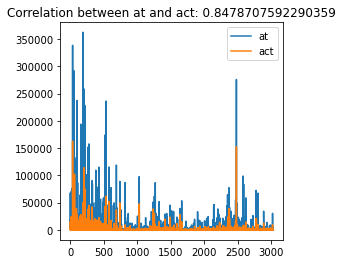

In [15]:
fig, ax = plt.subplots( figsize=(4,4))

plt.title(f"Correlation between at and act: {np.corrcoef( comp2019.dropna()['at'],comp2019.dropna()['act'])[0,1]}")

plt.plot(comp2019.dropna()['at'], label='at')
plt.plot(comp2019.dropna().act, label='act')
plt.legend()

plt.show()

In [16]:
# drop act
cols = [ 'at', 'emp', 'cik', 'naics']
comp2019 = comp2019[cols].copy()

In [17]:
# rescale
comp2019['at'] = 1000*comp2019['at']
comp2019['emp'] = 1000*comp2019['emp']

In [18]:
print('N. observations above 10 by column')
print(f"{comp2019[(comp2019['at']>10)].shape[0]} for at")
print(f"{comp2019[(comp2019['emp']>10)].shape[0]} for emp")

N. observations above 10 by column
3012 for at
2695 for emp


In [19]:
comp2019 = comp2019[(comp2019.emp>10)& (comp2019['at']>10)].copy() 

In [20]:
comp2019 = comp2019.dropna().copy() #2695
print(f'Shape of df after cleaning: {comp2019.shape}')

Shape of df after cleaning: (2695, 4)


In [21]:
comp2019['naics2'] = comp2019.naics.apply(lambda x: int(str(x)[:2]))

## Load similarities

In [22]:
#%%
X_countvec = np.load(data_path + 'X_countvec.npy')
X_tfidf = np.load(data_path + 'X_tfidf.npy')
X_LSA = np.load(data_path + 'X_LSA.npy')
X_NMF = np.load(data_path + 'X_NMF.npy')
X_lda = np.load(data_path + 'X_lda.npy')
X_d2v = np.load(data_path + 'X_d2v.npy')
X_tfidf_w2v_sg = np.load(data_path + 'X_tfidf_w2v_sg.npy')
X_avgw2v = np.load(data_path + 'X_avgw2v.npy')
X_tfidf_glove = np.load(data_path + 'X_tfidf_glove.npy')
X_avglove = np.load(data_path + 'X_avglove.npy')
X_avglove_pretrained = np.load(data_path + 'X_avglove_pretrained.npy')

In [23]:
####### COSINE SIMILARITIES
# %%
sims_countvec = cosine_similarity(X_countvec)
sims_tfidf = cosine_similarity(X_tfidf)
sims_lsa = cosine_similarity(X_LSA)
sims_nmf = cosine_similarity(X_NMF)
sims_lda = cosine_similarity(X_lda)
sims_d2v = cosine_similarity(X_d2v)
sims_tfidf_w2v_sg = cosine_similarity(X_tfidf_w2v_sg)
sims_avgw2v = cosine_similarity(X_avgw2v)
sims_tfidf_glove = cosine_similarity(X_tfidf_glove)
sims_avglove = cosine_similarity(X_avglove)
sims_avglove_pretrained = cosine_similarity(X_avglove_pretrained)
#%%

# Pair similarity of cik i to cik j with correspondent covariates

In [24]:
ciks_vocab = raw_data.to_dict()['cik']
ciks_vocab = {v:k for k,v in ciks_vocab.items()}

In [ ]:
# %%time
# 18 min

# matches = {'idx_pair':[], 'cik_pair':[],
# 'naics':[], 'naics2':[], 'emp':[], 'at':[], 'sims_countvec':[], 'sims_tfidf':[], 'sims_lsa':[], 'sims_nmf':[],
# 'sims_lda':[], 'sims_d2v':[], 'sims_tfidf_w2v_sg':[], 'sims_avgw2v':[], 'sims_tfidf_glove':[], 'sims_avglove':[],
#            'sims_avglove_pretrained':[]}
# for i in range(comp2019.shape[0]):
#     for j in range(i+1, comp2019.shape[0]):

#         row_i = comp2019.iloc[i].copy()
#         row_j = comp2019.iloc[j].copy()

#         cik_i = row_i.cik
#         cik_j = row_j.cik
#         matches['cik_pair'].append((cik_i,cik_j))

#         idx_i = ciks_vocab[cik_i]
#         idx_j = ciks_vocab[cik_j]
#         matches['idx_pair'].append((idx_i,idx_j))
#         matches['sims_countvec'].append(sims_countvec[idx_i, idx_j])
#         matches['sims_tfidf'].append(sims_tfidf[idx_i, idx_j])
#         matches['sims_lsa'].append(sims_lsa[idx_i, idx_j])
#         matches['sims_nmf'].append(sims_nmf[idx_i, idx_j])
#         matches['sims_lda'].append(sims_lda[idx_i, idx_j])
#         matches['sims_d2v'].append(sims_d2v[idx_i, idx_j])
        
#         matches['sims_tfidf_w2v_sg'].append(sims_tfidf_w2v_sg[idx_i, idx_j])
#         matches['sims_avgw2v'].append(sims_avgw2v[idx_i, idx_j])
#         matches['sims_tfidf_glove'].append(sims_tfidf_glove[idx_i, idx_j])
#         matches['sims_avglove'].append(sims_avglove[idx_i, idx_j])
#         matches['sims_avglove_pretrained'].append(sims_avglove_pretrained[idx_i, idx_j])
        

#         naics_i = row_i.naics
#         naics_j = row_j.naics
#         matches['naics'].append(1 if naics_i==naics_j else 0)
        
#         naics2_i = row_i.naics2
#         naics2_j = row_j.naics2
#         matches['naics2'].append(1 if naics2_i==naics2_j else 0)

#         for cov in ['at', 'emp']:
#             cov_i = row_i[cov]
#             cov_j = row_j[cov]
#             cov_val = np.log(cov_i/cov_j)
#             matches[cov].append(cov_val)
#     if i%200==0:
#         print(i)

In [ ]:
# filename = data_path + 'matches_dict.sav'
# with open(filename, 'wb') as f:
#     pickle.dump((matches), f)

In [25]:
filename = data_path + 'matches_dict.sav'
with open(filename, 'rb') as fr:
    matches = pickle.load(fr)

# Regression analysis: match sample to price data

In [26]:
df_all = pd.DataFrame.from_dict(matches)

In [27]:
df_all.cik_pair.head()

0    (1750.0, 3197.0)
1    (1750.0, 1800.0)
2    (1750.0, 2098.0)
3    (1750.0, 2186.0)
4    (1750.0, 2178.0)
Name: cik_pair, dtype: object

In [28]:
print('n. observations:', df_all.shape)

n. observations: (3630165, 17)


In [31]:
# merge in price data to later form correlation in returns in 2019
prices = pd.read_csv("daily_returns_2019.csv")
prices.head()

,PERMNO,date,TICKER,PERMCO,CUSIP,PRC,log_price,return,cik,tic
0,87432,20190103,A,36364,00846U10,63.27,4.147411,-0.037535,1090872,A
1,87432,20190104,A,36364,00846U10,65.46,4.181439,0.034028,1090872,A
2,87432,20190107,A,36364,00846U10,66.85,4.202451,0.021012,1090872,A
3,87432,20190108,A,36364,00846U10,67.83,4.217005,0.014553,1090872,A
4,87432,20190109,A,36364,00846U10,69.25,4.237723,0.020719,1090872,A


In [34]:
type(df_all.loc[0, "cik_pair"])

tuple

In [35]:
df_all["cik1"] = df_all["cik_pair"].apply(lambda x: int(x[0]))
df_all["cik2"] = df_all["cik_pair"].apply(lambda x: int(x[1]))

df_all.head()

,idx_pair,cik_pair,naics,naics2,emp,at,sims_countvec,sims_tfidf,sims_lsa,sims_nmf,sims_lda,sims_d2v,sims_tfidf_w2v_sg,sims_avgw2v,sims_tfidf_glove,sims_avglove,sims_avglove_pretrained,cik1,cik2
0,"(0, 9)","(1750.0, 3197.0)",0,0,1.872729,1.626815,0.740186,0.394291,0.952413,0.947263,0.918647,0.114133,0.950129,0.978689,0.945335,0.983872,0.989954,1750,3197
1,"(0, 1)","(1750.0, 1800.0)",0,0,-2.986430,-3.485958,0.613366,0.293499,0.863631,0.900804,0.802660,0.401232,0.933207,0.967690,0.924758,0.975147,0.981650,1750,1800
2,"(0, 2)","(1750.0, 2098.0)",0,0,2.505109,2.932376,0.565447,0.256880,0.743678,0.701206,0.558150,0.013688,0.937625,0.969352,0.931263,0.973529,0.979961,1750,2098
3,"(0, 4)","(1750.0, 2186.0)",0,0,3.884624,4.003636,0.704898,0.381424,0.921849,0.633801,0.807830,0.488416,0.947485,0.976324,0.943156,0.981751,0.987158,1750,2186
4,"(0, 3)","(1750.0, 2178.0)",0,1,2.095872,1.838001,0.605433,0.223159,0.950511,0.971372,0.712001,0.474086,0.923686,0.967690,0.938517,0.981137,0.988197,1750,2178


In [37]:
# only keep pairs where both have price data

cik_asset = set(prices.cik)
df_all = df_all[(df_all.cik1.isin(cik_asset)) & (df_all.cik2.isin(cik_asset))]
print(df_all.shape)

(2227105, 19)


In [40]:
SEED=879
sample =df_all.sample(50000, random_state=SEED)
print(sample.head())
sample.to_csv("sample_for_regression.csv", index=False)

             idx_pair                cik_pair  naics  naics2       emp  \
366129    (119, 1213)     (26172.0, 915779.0)      0       1  3.138452   
2563660  (3650, 3214)  (1651094.0, 1566469.0)      0       0  0.557460   
44331     (725, 1514)   (773840.0, 1041368.0)      0       0  6.105714   
203420    (648, 3960)   (733269.0, 1730430.0)      0       0  2.127536   
208696     (529, 812)    (356037.0, 810332.0)      0       0 -3.445802   

               at  sims_countvec  sims_tfidf  sims_lsa  sims_nmf  sims_lda  \
366129   3.969608       0.712806    0.420435  0.959959  0.911723  0.953553   
2563660  1.078557       0.737993    0.419978  0.891312  0.297139  0.520775   
44331    3.905883       0.599475    0.319807  0.753989  0.127137  0.082118   
203420   1.632137       0.595051    0.228558  0.717309  0.440149  0.023307   
208696  -3.196868       0.631900    0.249260  0.878344  0.903688  0.297719   

         sims_d2v  sims_tfidf_w2v_sg  sims_avgw2v  sims_tfidf_glove  \
366129   0.4642